# Project Report

## Navigating Germany's Rental Landscape for International Students

### Summary

<p> The project aims to analyze data concerning international students and rental properties in bayren, Germany. By examining this information, the project seeks to provide valuable insights to newcomers, helping them identify cities in bayren, Germany with the most favorable accommodation options and thus facilitating their transition to the country.</p>

### Project Flow

1. Data Acquisition:
- Obtain the Nuremberg Stops dataset from the provided metadata URL and download the corresponding xlsx file.
- Obtain the Foreign students dataset from the provided metadata URL and download the corresponding xlsx file.

Datasource1: Foreign students in Germany
- Metadata URL: https://data.europa.eu/data/datasets/https-www-datenportal-bmbf-de-portal-2-5-34
- Data URL: https://www.datenportal.bmbf.de/portal/Tabelle-2.5.34.xls
- Data Type: xlsx

This dataset comprises information about international students admitted to degree programs in  bayren Germany over a specific time period. It includes data on the students' nationalities, degree programs, admission dates, and other relevant attributes.

Datasource2: Immoscout24 dataset
- Metadata URL: https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany
- Data URL: https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany/download?datasetVersionNumber=6
- Data Type: xlsx

This dataset comprises information about rental property listings from Immoscout24, which is the largest real estate platform in bayren Germany. It includes details about rental prices, property characteristics, and the property's location.

In [2]:
# Import all necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3  

# Connect to the database
conn = sqlite3.connect('datasets.sqlite')  

# Query the database and load data into a DataFrames
immoscout_table = f"SELECT * FROM immoscout"
immoscout_df = pd.read_sql_query(immoscout_table, conn)

intstudents_table = f"SELECT * FROM intstudents"
intstudents_df = pd.read_sql_query(intstudents_table, conn)

# Close the database connection
conn.close()


In [13]:
# List of columns to convert from float64 to int
columns = ['Humanities', 'Social sciences', 'Mathematics',
                 'Engineering sciences', 'Computer Science',
                 'medizin', 'Agriculture']

# Convert selected columns to int
intstudents_df[columns] = intstudents_df[columns].astype(int)


# Calculate total students and add a new column
intstudents_df['total_students'] = intstudents_df[columns].sum(axis=1)



intstudents_current_year = intstudents_df[intstudents_df['winter-semester'] == '2022/2023']

intstudents_current_year.columns


Index(['Region', 'Universität', 'Stadt', 'winter-semester', 'Humanities',
       'Social sciences', 'Mathematics', 'Engineering sciences',
       'Computer Science', 'medizin', 'Agriculture', 'latitude', 'longitude',
       'total_students'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


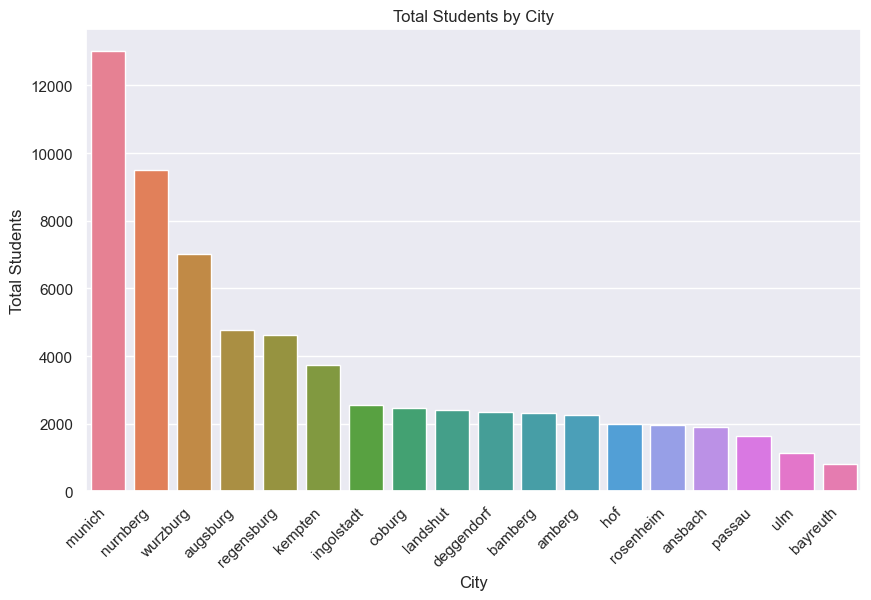

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the provided columns
# If your DataFrame has different column names, adjust them accordingly
columns_to_use = ['Stadt', 'total_students']
df_bar = intstudents_current_year[columns_to_use].groupby('Stadt').sum()

# Sort the DataFrame by total_students in ascending order
df_bar = df_bar.sort_values(by='total_students', ascending=False)

# Set a seaborn color palette for different cities
city_palette = sns.color_palette("husl", n_colors=len(df_bar))

# Plot the compound bar graph using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=df_bar.index, y='total_students', data=df_bar, palette=city_palette, hue=df_bar.index)

ax.set_xlabel('City')
ax.set_ylabel('Total Students')
ax.set_title('Total Students by City')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Remove the legend, as it's not needed in this case
ax.legend().set_visible(False)

plt.show()



In [145]:
df_bar

,total_students
Stadt,
munich,13003
nurnberg,9507
wurzburg,7018
augsburg,4784
regensburg,4615
kempten,3725
ingolstadt,2565
coburg,2458
landshut,2395


In [146]:
intstudents_df = intstudents_df.dropna()

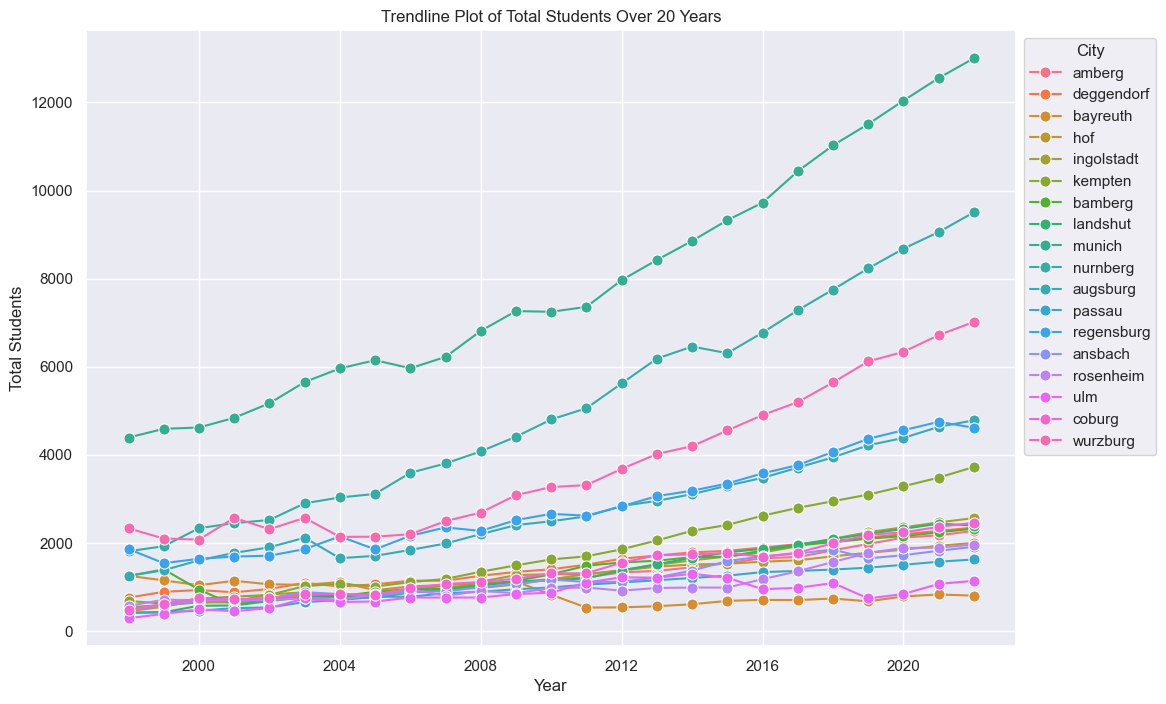

In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator

# Assuming intstudents_df is your DataFrame
# If your DataFrame has different column names, adjust them accordingly
columns_to_use = ['Stadt', 'winter-semester', 'total_students']
df_trendline = intstudents_df[columns_to_use].copy()

# Extract the year from 'winter-semester' and convert it to datetime
df_trendline['year'] = pd.to_datetime(df_trendline['winter-semester'].str.split('/').str[0], format='%Y')
df_trendline_grouped = df_trendline.groupby(['Stadt', 'year'])['total_students'].sum().reset_index()

# Sort the DataFrame by 'year'
df_trendline_grouped = df_trendline_grouped.sort_values(by='year')

sns.set(style="darkgrid")

# Create a trendline plot
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='year', y='total_students', hue='Stadt', data=df_trendline_grouped, errorbar=None, marker='o', markersize=8)

plt.title('Trendline Plot of Total Students Over 20 Years')
plt.xlabel('Year')
plt.ylabel('Total Students')
plt.legend(title='City', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


In [148]:
immoscout_df.columns

Index(['federalState', 'serviceCharge', 'heatingType', 'telekomTvOffer',
       'telekomHybridUploadSpeed', 'newlyConst', 'balcony', 'pricetrend',
       'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'noParkSpaces',
       'firingTypes', 'hasKitchen', 'cellar', 'yearConstructedRange',
       'baseRent', 'houseNumber', 'livingSpace', 'condition', 'interiorQual',
       'petsAllowed', 'street', 'streetPlain', 'lift', 'baseRentRange',
       'typeOfFlat', 'zipCode', 'noRooms', 'thermalChar', 'floor',
       'numberOfFloors', 'noRoomsRange', 'garden', 'livingSpaceRange',
       'district', 'cityTown', 'description', 'facilities', 'heatingCosts',
       'energyEfficiencyClass', 'lastRefurbish', 'electricityBasePrice',
       'electricityKwhPrice', 'date'],
      dtype='object')

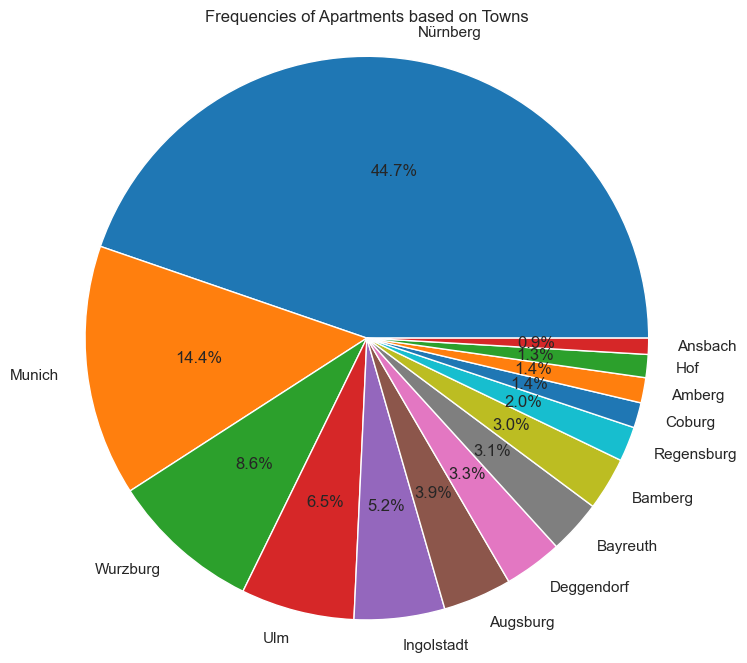

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'cityTown' column contains the town information
apartments_wrt_town = immoscout_df['district'].value_counts()

# Sort the values for better visualization
apartments_wrt_town_sorted = apartments_wrt_town.sort_values(ascending=False)

# Set a seaborn color palette for different cities
town_palette = sns.color_palette("tab10", n_colors=len(apartments_wrt_town_sorted))

# Plot the pie chart using seaborn
plt.figure(figsize=(8, 8))
plt.pie(apartments_wrt_town_sorted.values, labels=apartments_wrt_town_sorted.index, autopct='%1.1f%%', colors=town_palette)
plt.title('Frequencies of Apartments based on Towns')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


In [184]:
intstudents_df.columns

Index(['Region', 'Universität', 'Stadt', 'winter-semester', 'Humanities',
       'Social sciences', 'Mathematics', 'Engineering sciences',
       'Computer Science', 'medizin', 'Agriculture', 'latitude', 'longitude',
       'total_students'],
      dtype='object')

In [185]:
immoscout_df['noRooms']

0       2.0
1       2.0
2       3.0
3       3.0
4       5.0
       ... 
4002    3.0
4003    2.2
4004    4.0
4005    4.5
4006    3.0
Name: noRooms, Length: 4007, dtype: float64

In [186]:
# Filter the DataFrame to include only rows where 'noRooms' is an integer
filtered_df = immoscout_df[immoscout_df['noRooms'].astype(int) == immoscout_df['noRooms']]

# Group by 'district' and calculate the total number of rooms in each district
total_rooms_per_district = filtered_df.groupby('district')['noRooms'].sum().reset_index()

total_rooms_per_district.head()

,district,noRooms
0,Amberg,141.0
1,Ansbach,84.0
2,Augsburg,333.0
3,Bamberg,284.0
4,Bayreuth,281.0


In [187]:
columns_to_use = ['Stadt', 'total_students']
df_bar = intstudents_current_year[columns_to_use].groupby('Stadt').sum()
df_bar.reset_index(inplace=True)
df_bar.rename(columns={'Stadt': 'district'}, inplace=True)
df_bar.head()

,district,total_students
0,amberg,2273
1,ansbach,1913
2,augsburg,4784
3,bamberg,2324
4,bayreuth,802


In [188]:
total_rooms_per_district['district'] = total_rooms_per_district['district'].str.lower()
total_rooms_per_district.columns

Index(['district', 'noRooms'], dtype='object')

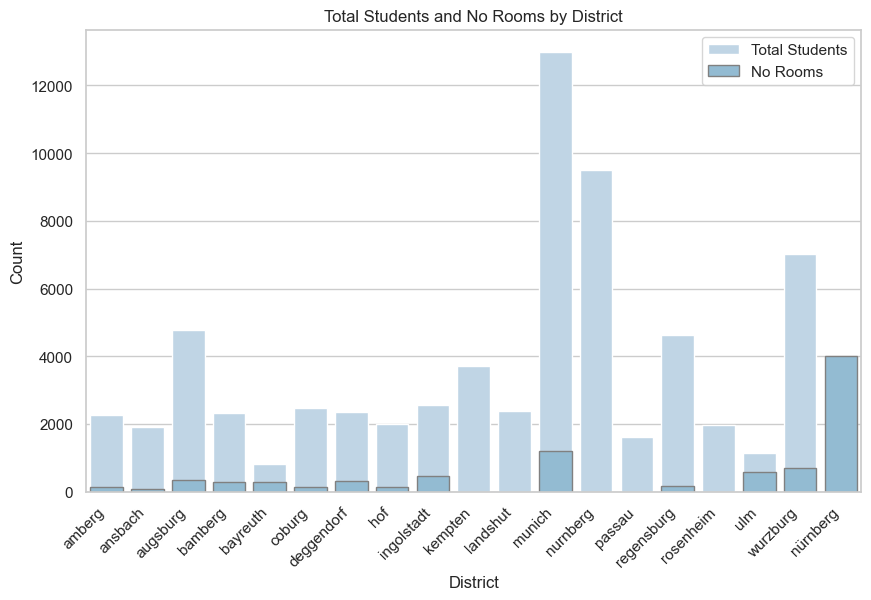

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style to 'whitegrid' for a light background
sns.set_style("whitegrid")

# Assuming df_bar and total_rooms_per_district are your DataFrames
# If your DataFrames have different column names, adjust them accordingly

# Create a bar plot with visually attractive color scheme
plt.figure(figsize=(10, 6), facecolor='None')  # Set facecolor to 'None' for transparent background

# Define visually attractive colors
total_students_color = sns.color_palette("Blues")[1]  # A shade of blue
no_rooms_color = sns.color_palette("Blues")[2]  # A shade of gray

sns.barplot(x='district', y='total_students', data=df_bar, color=total_students_color, label='Total Students')
sns.barplot(x='district', y='noRooms', data=total_rooms_per_district, color=no_rooms_color, edgecolor='grey', label='No Rooms')

# Set labels and title
plt.xlabel('District')
plt.ylabel('Count')
plt.title('Total Students and No Rooms by District')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
# Display the legend
plt.legend()

# Show the plot
plt.show()
